### Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

### Path to dataset. 
* This dataset is downloaded from Kaggle https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

In [2]:
# Data path and dataframe for files.

Data = r"./data/TESS Toronto emotional speech set data/"
tess_directory_list = os.listdir(Data)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Data + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        file_emotion.append(part)
        file_path.append(Data + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

data_path = pd.concat([Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,./data/TESS Toronto emotional speech set data/...
1,angry,./data/TESS Toronto emotional speech set data/...
2,angry,./data/TESS Toronto emotional speech set data/...
3,angry,./data/TESS Toronto emotional speech set data/...
4,angry,./data/TESS Toronto emotional speech set data/...


Visualisation

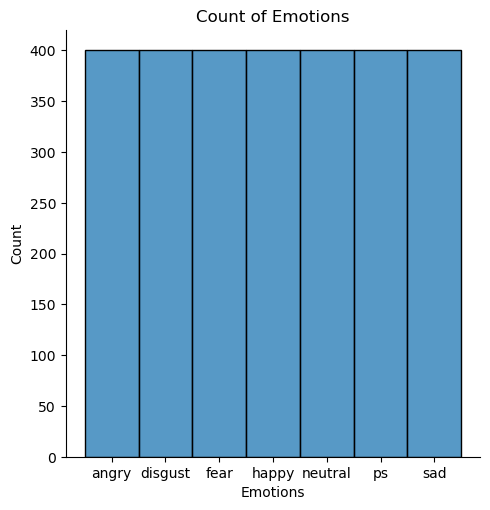

In [3]:
sns.displot(data_path.Emotions)
plt.ylabel('Count', size=10)
plt.xlabel('Emotions', size=10)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Count of Emotions', size=12)
plt.show()

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

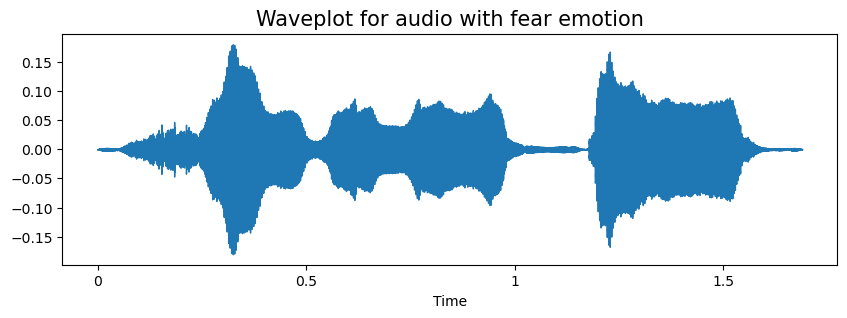

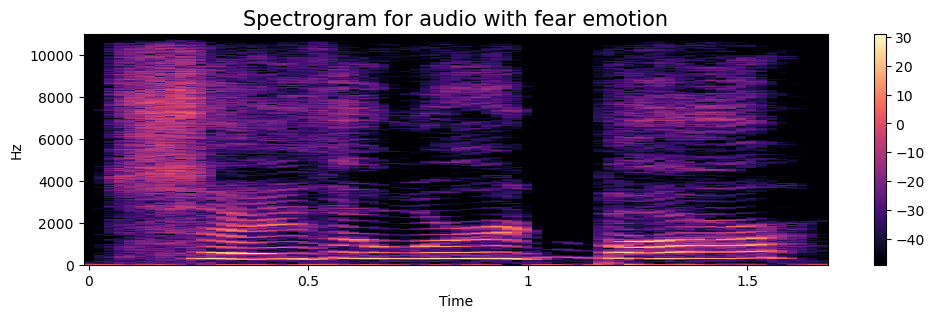

In [5]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

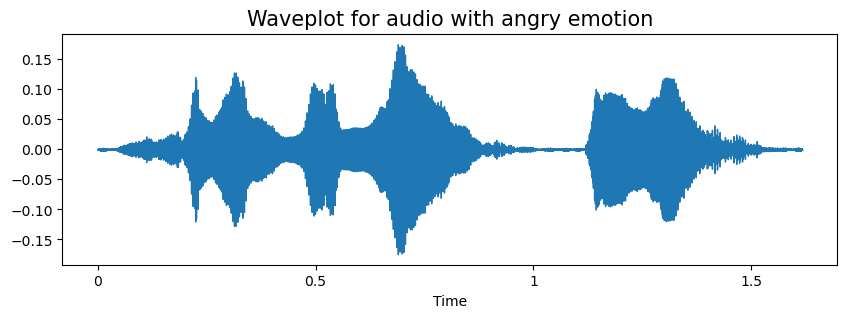

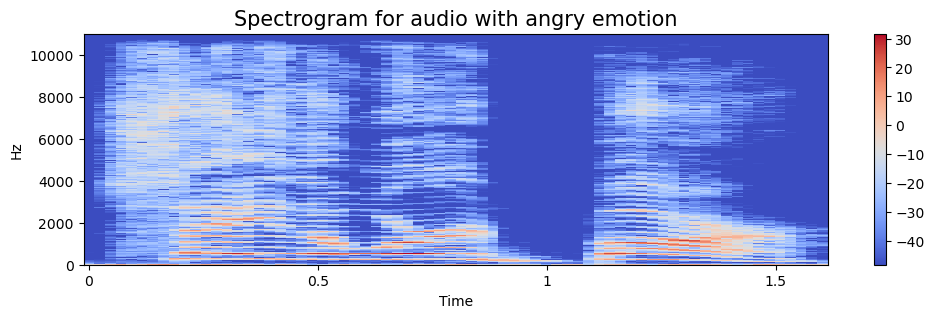

In [6]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

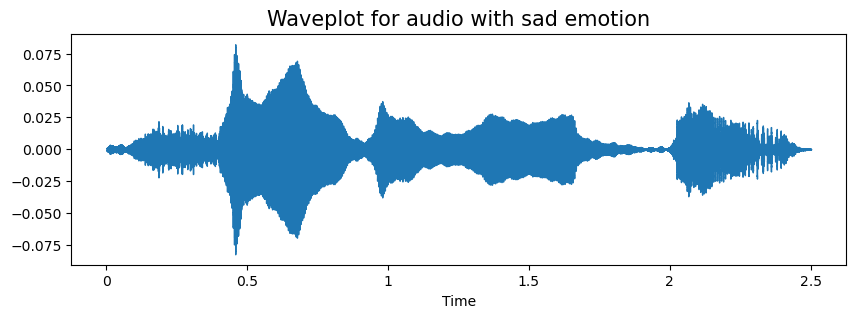

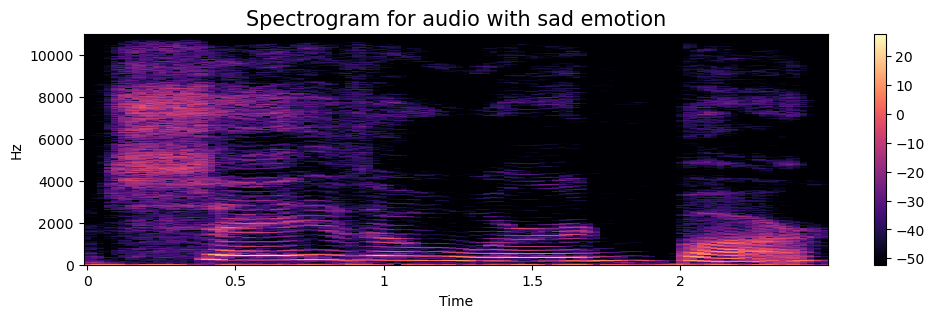

In [7]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

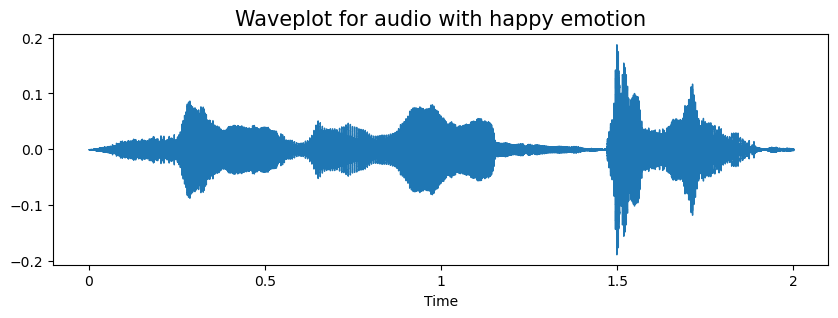

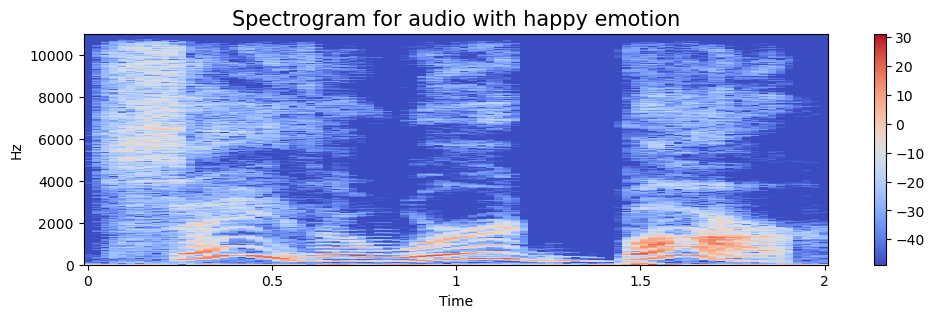

In [8]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [9]:
def noise(data):
    noise_amp = 0.35*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=3)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

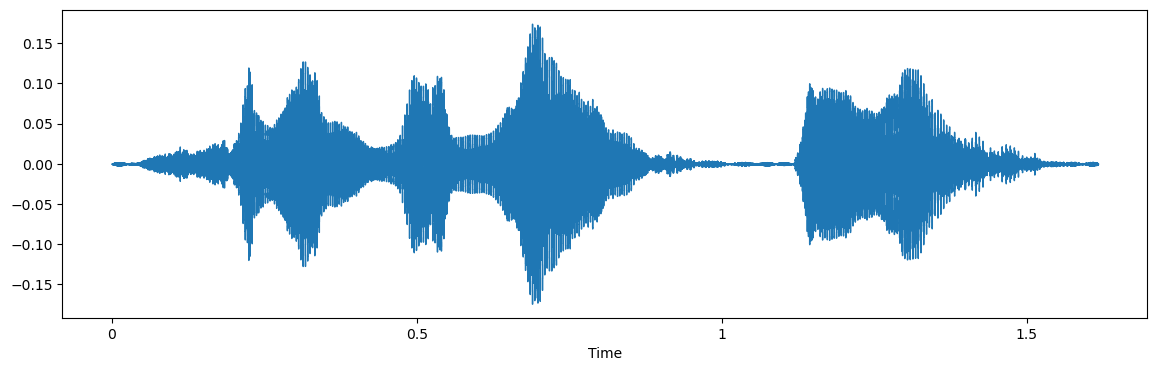

In [10]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

Feature extraction using MFCC

In [11]:
def extract_features(data):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    return result

In [12]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [13]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [14]:
len(X), len(Y), data_path.Path.shape


(8400, 8400, (2800,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-398.608246,75.117401,-21.772625,-19.993965,2.985435,13.788046,-19.953243,-7.025359,-5.187742,1.833246,...,1.479892,2.302237,2.201618,1.957095,1.105945,-5.587186,-4.650013,-2.491658,-9.133067,angry
1,-298.815700,43.087685,-13.042016,-18.483821,0.856893,7.638581,-9.371724,-6.171427,-3.140897,0.918065,...,-0.965969,-0.023054,1.451545,1.968807,-0.378355,-3.874055,-3.064910,-2.224572,-7.484251,angry
2,-430.501648,66.726631,-36.950680,-23.967577,11.113916,-3.656210,-25.287195,0.632061,-2.124413,6.094216,...,4.251060,-2.075624,-0.130830,-8.069338,-9.255156,-9.579614,-5.671675,-9.212944,8.009422,angry
3,-469.633392,101.032448,1.475380,-32.444489,-9.686409,14.370925,-1.291309,-5.177819,-9.246144,5.867874,...,10.429773,-1.341168,1.275015,-0.199243,-1.488937,-7.783144,-5.000467,-2.176940,-8.113317,angry
4,-274.258116,30.135870,1.172386,-13.071131,-6.022887,2.266348,2.573785,-1.732938,-5.132220,-2.543355,...,1.953373,0.923669,1.276415,-0.054380,-3.339597,-3.717703,-3.343171,-3.138309,-4.544034,angry


Data Preparation

In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((6300, 20), (6300, 7), (2100, 20), (2100, 7))

In [19]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 20), (6300, 7), (2100, 20), (2100, 7))

In [20]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 20, 1), (6300, 7), (2100, 20, 1), (2100, 7))

In [28]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


C:\Users\Leapfrog\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 20, 256)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 10, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 5, 128)              │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 3, 64)               │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,823 (2.06 MB)

 Trainable params: 538,823 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [22]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2989 - loss: 1.7093 - val_accuracy: 0.5567 - val_loss: 1.1900 - learning_rate: 0.0010
Epoch 2/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5799 - loss: 1.1348 - val_accuracy: 0.7505 - val_loss: 0.7116 - learning_rate: 0.0010
Epoch 3/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7114 - loss: 0.8158 - val_accuracy: 0.7752 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 4/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7730 - loss: 0.6632 - val_accuracy: 0.7895 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 5/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8253 - loss: 0.5362 - val_accuracy: 0.8652 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 6/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8371 - loss: 0.4870 - val_accuracy: 0.8657 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 7/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8426 - loss: 0.4516 - val_acc

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9320 - loss: 0.3470
Accuracy of our model on test data :  93.28571557998657 %


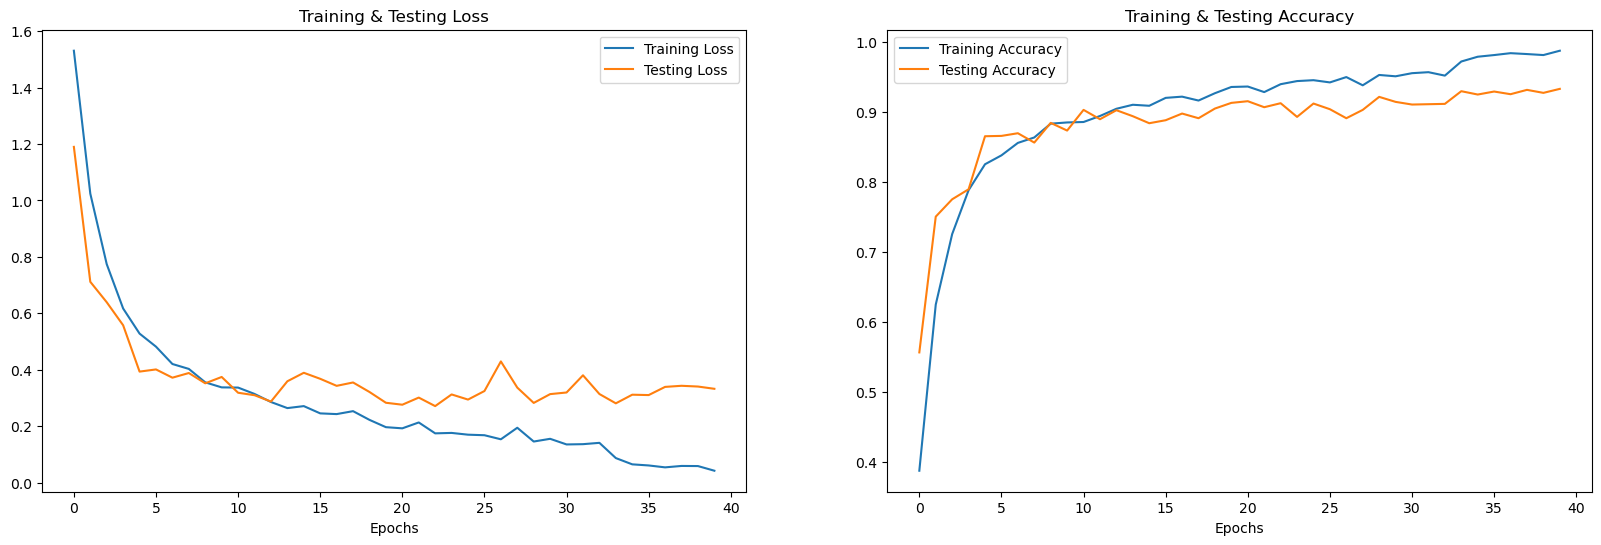

In [23]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

###  Predection

In [24]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [25]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,ps,ps
2,neutral,neutral
3,happy,happy
4,ps,ps
5,fear,fear
6,fear,fear
7,sad,sad
8,angry,disgust
9,fear,fear


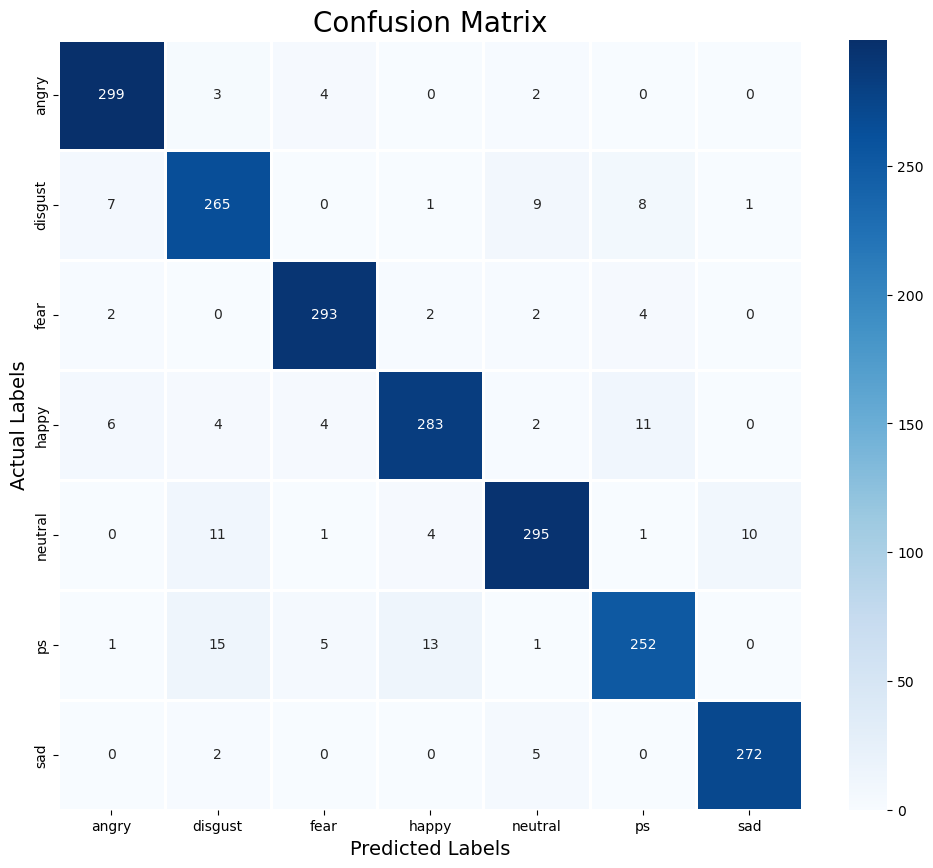

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.95      0.97      0.96       308
     disgust       0.88      0.91      0.90       291
        fear       0.95      0.97      0.96       303
       happy       0.93      0.91      0.92       310
     neutral       0.93      0.92      0.92       322
          ps       0.91      0.88      0.90       287
         sad       0.96      0.97      0.97       279

    accuracy                           0.93      2100
   macro avg       0.93      0.93      0.93      2100
weighted avg       0.93      0.93      0.93      2100

